<a href="https://colab.research.google.com/github/SebIngB/TraductorESPtoENG/blob/main/Model_translation_RNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!nvidia-smi

/bin/bash: nvidia-smi: command not found


In [ ]:
!pip install "tensorflow-text>=2.11"
!pip install einops

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## Imports

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import tensorflow as tf
import tensorflow_text as tf_text
import einops

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input, GRU, Embedding
from tensorflow.keras.utils import plot_model

Verifica la coherencia de las dimensiones, donde se busca mantener un cache de las dimensiones adecuadas

In [ ]:
#@title
class ShapeChecker():
  def __init__(self):
    # Keep a cache of every axis-name seen
    self.shapes = {}

  def __call__(self, tensor, names, broadcast=False):
    if not tf.executing_eagerly():
      return

    parsed = einops.parse_shape(tensor, names)

    for name, new_dim in parsed.items():
      old_dim = self.shapes.get(name, None)

      if (broadcast and new_dim == 1):
        continue

      if old_dim is None:
        # If the axis name is new, add its length to the cache.
        self.shapes[name] = new_dim
        continue

      if new_dim != old_dim:
        raise ValueError(f"Shape mismatch for dimension: '{name}'\n"
                         f"    found: {new_dim}\n"
                         f"    expected: {old_dim}\n")

In [ ]:
# Download the file
import pathlib

path_to_zip = tf.keras.utils.get_file(
    'spa-eng.zip', origin='http://storage.googleapis.com/download.tensorflow.org/data/spa-eng.zip',
    extract=True)

path_to_file = pathlib.Path(path_to_zip).parent/'spa-eng/spa.txt'

In [ ]:
def load_data(path):
  text = path.read_text(encoding='utf-8')

  lines = text.splitlines()
  pairs = [line.split('\t') for line in lines]

  context = np.array([context for target, context in pairs])
  target = np.array([target for target, context in pairs])

  return target, context

In [ ]:
target_raw, context_raw = load_data(path_to_file)

In [ ]:
print(len(context_raw))
print(len(target_raw))

118964
118964


In [ ]:
random_mix_size = len(context_raw) #Tamaño de la mezcla aleatoria del dataset, donde si es igual al tamaño del conjunto de datos, todos los datos tendra la misma probabilidad de seleccionarse en cada iteración
BATCH_SIZE = 64 # Tamaño del lote de los elementos del dataset que se van agrupar

is_train = np.random.uniform(size=(len(target_raw),)) < 0.8 #Generación aleatoria de la cantidad de datos de train a usar, donde se selecciona el 80% de los datos para el entrenamiento

train_raw = (
    tf.data.Dataset
    .from_tensor_slices((context_raw[is_train], target_raw[is_train])) #Creación del conjunto de datos apartir de Tensorflow donde van a estar el 80% de los datos para entrenamiento
    .shuffle(random_mix_size) # Mezcla aleatoriamente los elementos del conjunto de datos, dando la misma probabilidad a todos los elementos
    .batch(BATCH_SIZE)) # Agrupa los elementos del conjunto de datos en lotes más pequeños

val_raw = (
    tf.data.Dataset
    .from_tensor_slices((context_raw[~is_train], target_raw[~is_train]))#Creación del conjunto de datos apartir de Tensorflow donde van a estar el 20% de los datos para testeo
    .shuffle(random_mix_size)
    .batch(BATCH_SIZE))

In [ ]:
for example_context_strings, example_target_strings in train_raw.take(2): #take() toma cada lote del conjunto de datos de entrenamiento
  print(len(example_context_strings))
  print()
  print(len(example_target_strings))
  break

64

64


In [ ]:
print(example_context_strings[:10].numpy(), '\n')
print(example_target_strings[:10].numpy())

[b'No hay se\xc3\xb1ales de vida en Marte.'
 b'Debe de ser dif\xc3\xadcil para vosotras.'
 b'Le agradezco mucho por su ayuda.'
 b'Tom\xc3\xa1s quiere mudarse aqu\xc3\xad.' b'Esto es muy arriesgado.'
 b'Estoy de acuerdo.' b'No significa nada.' b'Haz que suceda.'
 b'Te quiero tomar la temperatura.'
 b'Hoy d\xc3\xada estoy realmente cansado.'] 

[b'There is no sign of life on Mars.' b'It must be hard for you.'
 b'I am grateful to you for your help.' b'Tom wants to move here.'
 b'This is very risky.' b'I agree.' b"It doesn't have any significance."
 b'Make it happen.' b'I want to take your temperature.'
 b"I'm really tired today."]


In [ ]:
example_text = tf.constant('¿Todavía está en casa?') #Se utiliza para mantener fijo el texto e inmutable, que no se puede modificar el contenido, en este caso el texto

print(example_text.numpy()) # Se realiza la representación del texto en una cadena de bytes con el numpy()
print(tf_text.normalize_utf8(example_text, 'NFKD').numpy())

b'\xc2\xbfTodav\xc3\xada est\xc3\xa1 en casa?'
b'\xc2\xbfTodavi\xcc\x81a esta\xcc\x81 en casa?'


-> **tf_text.normalize_utf8(example_text, 'NFKD').numpy()** => Normaliza el texto por medio de Unicode NFKD que se utiliza para descomponer los caracteres del texto especiales en sus formas basicas y se realiza la normalización Unicode de dichos caracteres para que tengan equivalencia donde algunos caracteres tienen la misma apariencia o significado pero se representan de forma distinta, por lo que toca colocarlos en una forma unificada/universal.

In [ ]:
def tf_lower_and_split_punct(text):
  # Split accented characters.
  text = tf_text.normalize_utf8(text, 'NFKD') #Aplica la normalización a la cadena de texto
  text = tf.strings.lower(text) #Convierte la cadena de texto que tengan mayusculas a minusculas

  # Keep space, a to z, and select punctuation.
  text = tf.strings.regex_replace(text, '[^ a-z.?!,¿]', '') # Reemplaza la cadena de texto por espacios en blanco excepto a los caracteres [^ a-z.?!,¿] por lo que el resto se eliminaran

  # Add spaces around punctuation.
  text = tf.strings.regex_replace(text, '[.?!,¿]', r' \0 ') # Agrega espacios antes y despues de los caracteres '[.?!,¿]', y es debido a que se esta utilizando r' \0 ' el encargado de agregar espacios antes y despues

  # Strip whitespace.
  text = tf.strings.strip(text) # Elimina los espacios al inicio y al final de una cadena de texto

  text = tf.strings.join(['[START]', text, '[END]'], separator=' ') # Agrega [START] al inicio y [END] al final de la cadena de texto y los separa por espacio
  return text

In [ ]:
print(example_text) # decode() decodifica la cadena de texto
print(tf_lower_and_split_punct(example_text))

tf.Tensor(b'\xc2\xbfTodav\xc3\xada est\xc3\xa1 en casa?', shape=(), dtype=string)
tf.Tensor(b'[START] \xc2\xbf todavia esta en casa ? [END]', shape=(), dtype=string)


Ahora se va a volver la cadena de texto normalizada en formato vectorial de tokens, donde se utiliza lo siguiente:

-> tf.keras.layers.TextVectorization => Se utiliza para vectorizar la cadena de texto donde cada numero representa un token único del texto donde dicho texto se reprsenta por medio de un numero entero, donde le proporciono el metodo de estandarización del texto, y el maximo de tokens que se crearan.

El token '[UNK]' representa las palabras desconocidas que no se encuentran dentro del vocabulario

In [ ]:
max_vocab_size = 5000 # Tamaño maximo de tokens que se van a crear

context_text_processor = tf.keras.layers.TextVectorization(
    standardize=tf_lower_and_split_punct,
    max_tokens=max_vocab_size,
    ragged=True) # Se le indica que son longitudes de texto irregular, por lo que varia

In [ ]:
context_text_processor.adapt(train_raw.map(lambda context, target: context)) # Se utiliza el metodo adapt para pasar el conjuto de datos de entrenamiento. Se utiliza el metodo map para aplicar una función a cada elemento
                                                                             # del conjunto de datos, en este caso es seleccionar solo el context de los datos de entrenamiento
# Here are the first 10 words from the vocabulary:
print(context_text_processor.get_vocabulary()[:10]) #Obtengo los valores de texto de los tokens
print(len(context_text_processor.get_vocabulary()))

['', '[UNK]', '[START]', '[END]', '.', 'que', 'de', 'el', 'a', 'no']
5000


In [ ]:
target_text_processor = tf.keras.layers.TextVectorization(
    standardize=tf_lower_and_split_punct,
    max_tokens=max_vocab_size,
    ragged=True)

target_text_processor.adapt(train_raw.map(lambda context, target: target))
target_text_processor.get_vocabulary()[:10]

['', '[UNK]', '[START]', '[END]', '.', 'the', 'i', 'to', 'you', 'tom']

In [ ]:
example_tokens = context_text_processor(example_context_strings) # Procesa los datos de ejemplo de contexto de entrenamiento
print(example_tokens[:3])
print(example_tokens[:3].numpy())

<tf.RaggedTensor [[2, 9, 60, 4051, 6, 148, 14, 4831, 4, 3],
 [2, 304, 6, 81, 205, 32, 1962, 4, 3],
 [2, 28, 2489, 77, 21, 25, 209, 4, 3]]>
[array([   2,    9,   60, 4051,    6,  148,   14, 4831,    4,    3])
 array([   2,  304,    6,   81,  205,   32, 1962,    4,    3])
 array([   2,   28, 2489,   77,   21,   25,  209,    4,    3])]


In [ ]:
context_vocab = np.array(context_text_processor.get_vocabulary()) # Convierto el vocabulario de mi procesador en una array numpy
print(context_vocab[:10])
print(example_tokens[0].numpy())
tokens = context_vocab[example_tokens[0].numpy()] # Extraigo el texto por medio de la secuencia de numeros de los tokens que entrega al procesar los textos de ejemplos del contexto de entrenamiento
print(tokens)
' '.join(tokens)

['' '[UNK]' '[START]' '[END]' '.' 'que' 'de' 'el' 'a' 'no']
[   2    9   60 4051    6  148   14 4831    4    3]
['[START]' 'no' 'hay' 'senales' 'de' 'vida' 'en' 'marte' '.' '[END]']


'[START] no hay senales de vida en marte . [END]'

Text(0.5, 1.0, 'Mask')

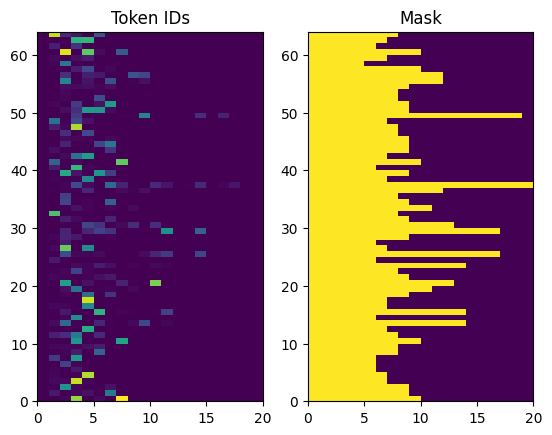

In [ ]:
plt.subplot(1, 2, 1)
plt.pcolormesh(example_tokens.to_tensor())
plt.title('Token IDs')

plt.subplot(1, 2, 2)
plt.pcolormesh(example_tokens.to_tensor() != 0)
plt.title('Mask')

In [ ]:
for context, target in train_raw.take(1):
  target = target_text_processor(target)
  print(target[:5,:])
  print(target[:5,:-1])
  print(target[:5,1:],'\n')
  print(tf.size(target))
  print(tf.size(target[:,:-1]))
  print(tf.size(target[:,1:]))

<tf.RaggedTensor [[2, 9, 38, 133, 920, 91, 93, 31, 134, 19, 95, 13, 859, 920, 106, 1109, 4,
  3]                                                                      ,
 [2, 9, 233, 10, 674, 1330, 352, 1027, 601, 7, 80, 7, 5, 698, 7, 604, 201,
  608, 4, 3]                                                              ,
 [2, 50, 54, 4844, 21, 90, 1, 16, 6, 941, 86, 230, 17, 4, 3],
 [2, 328, 67, 232, 7, 17, 4, 3], [2, 9, 904, 379, 14, 5, 1183, 3604, 4, 3]]>
<tf.RaggedTensor [[2, 9, 38, 133, 920, 91, 93, 31, 134, 19, 95, 13, 859, 920, 106, 1109, 4],
 [2, 9, 233, 10, 674, 1330, 352, 1027, 601, 7, 80, 7, 5, 698, 7, 604, 201,
  608, 4]                                                                 ,
 [2, 50, 54, 4844, 21, 90, 1, 16, 6, 941, 86, 230, 17, 4],
 [2, 328, 67, 232, 7, 17, 4], [2, 9, 904, 379, 14, 5, 1183, 3604, 4]]>
<tf.RaggedTensor [[9, 38, 133, 920, 91, 93, 31, 134, 19, 95, 13, 859, 920, 106, 1109, 4, 3],
 [9, 233, 10, 674, 1330, 352, 1027, 601, 7, 80, 7, 5, 698, 7, 604, 201, 608

Se extraer el [END] y el [START] del target de los datos de entrenamiento debido a que para entrenar el modelo a keras se le pasa pares de (inputs, labels) por lo que toca separarlo para que en la construcción del modelo el aprenda la localizacion del token final [END] para la parte codificadora

In [ ]:
def process_text(context, target):
  context = context_text_processor(context).to_tensor() # Convierte el procesamiento de los datos de contexto de entrenamiento en tensores para mayor eficiencia computacional
  target = target_text_processor(target) # Proceso los datos de target de los datos de entrenamiento

  targ_in = target[:,:-1].to_tensor() # Conversion a tensor de los datos de target de entrenamiento donde excluyo el ultimo valor del token de la columna que es [END]
  targ_out = target[:,1:].to_tensor() # Conversion a tensor de los datos de target de entrenamiento donde excluyo el primer valor del token de la columna que es [START]

  return (context, targ_in), targ_out


train_ds = train_raw.map(process_text, tf.data.AUTOTUNE) # tf.data.AUTOTUNE ajusta de forma automatica la cantidad de recursos para acelerar la carga y la transformación de datos, optimizando así el rendimiento del pipeline de datos.
val_ds = val_raw.map(process_text, tf.data.AUTOTUNE)

In [ ]:
for (ex_context_tok, ex_tar_in), ex_tar_out in train_ds.take(1):
  print(ex_context_tok[0, :].numpy())
  print(ex_tar_in[0, :].numpy())
  print(ex_tar_out[0, :].numpy(), '\n')

  print(ex_context_tok.numpy().shape)
  print(ex_tar_in.numpy().shape)
  print(ex_tar_out.numpy().shape)

[  2  10 116   5  99 613   4   3   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0]
[  2   9 262  39 607   4   0   0   0   0   0   0   0   0   0   0   0   0
   0   0]
[  9 262  39 607   4   3   0   0   0   0   0   0   0   0   0   0   0   0
   0   0] 

(64, 24)
(64, 20)
(64, 20)


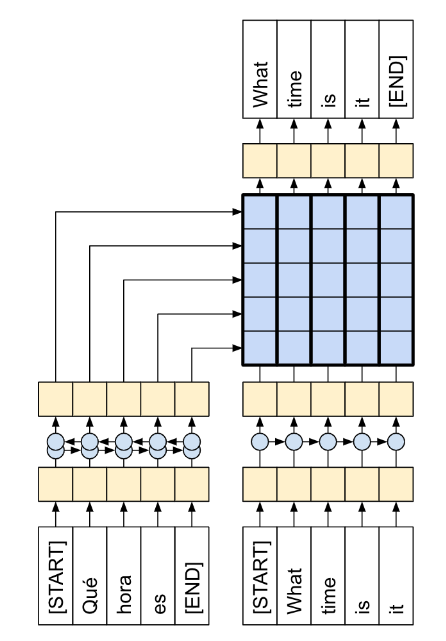

## Encoder

In [ ]:
latent_dim = 256 # Hace referencia a las unidades o estados ocultos en el estado interno de la LSTM o la GRU

-> **merge_mode:** se utiliza para especificar como se fusionan las salidas de las capa RNN bidireccionales, donde se utilizan redes bidireccionales debido a que pueden capturar la información tanto anterior como posterior y entender el contexto de una secuencia

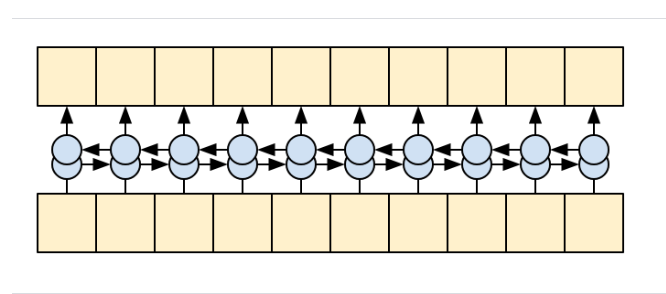

In [ ]:
class Encoder(tf.keras.layers.Layer):
  def __init__(self, text_processor, units):
    super(Encoder, self).__init__()
    self.text_processor = text_processor
    self.vocab_size = text_processor.vocabulary_size() # 5000
    self.units = units

    # The embedding layer converts tokens to vectors
    self.embedding = Embedding(self.vocab_size, units, mask_zero=True)

    # The RNN layer processes those vectors sequentially.
    self.rnn = tf.keras.layers.Bidirectional(merge_mode='sum', layer=GRU(units, # Return the sequence and state
                                                                                  return_sequences=True, recurrent_initializer='glorot_uniform'))

  def call(self, x):
    shape_checker = ShapeChecker()
    shape_checker(x, 'batch s')

    # 2. The embedding layer looks up the embedding vector for each token.
    x = self.embedding(x)
    shape_checker(x, 'batch s units')

    # 3. The GRU processes the sequence of embeddings.
    x = self.rnn(x)
    shape_checker(x, 'batch s units')
    # 4. Returns the new sequence of embeddings.

    return x

  def convert_input(self, texts):
    texts = tf.convert_to_tensor(texts)
    if len(texts.shape) == 0:
      texts = tf.convert_to_tensor(texts)[tf.newaxis]
    context = self.text_processor(texts).to_tensor()
    context = self(context)

    return context

In [ ]:
# Encode the input sequence.
encoder = Encoder(context_text_processor, latent_dim)
ex_context = encoder(ex_context_tok)

print(f'Context tokens, shape (batch, s): {ex_context_tok.shape}')
print(f'Encoder output, shape (batch, s, units): {ex_context.shape}')

Context tokens, shape (batch, s): (64, 24)
Encoder output, shape (batch, s, units): (64, 24, 256)


## Attention

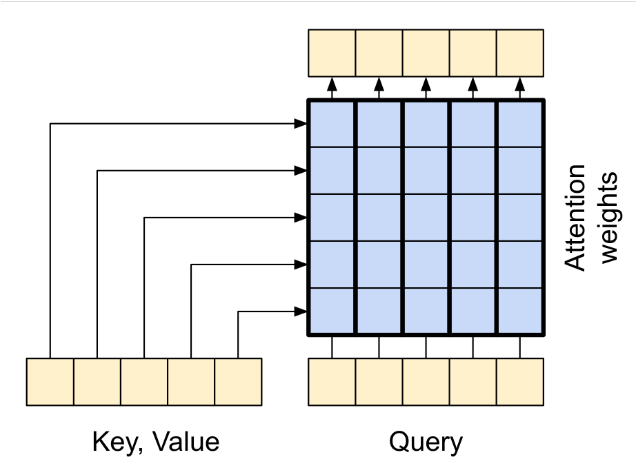

In [ ]:
class CrossAttention(tf.keras.layers.Layer):
  def __init__(self, units, **kwargs):
    super().__init__()
    self.mha = tf.keras.layers.MultiHeadAttention(key_dim=units, num_heads=1, **kwargs)
    self.layernorm = tf.keras.layers.LayerNormalization() #Sirve para normalizar la salida del modelo donde tenga una media cercana a 0 y una varianza cercana a 1 para estabilizar y acelerar el entrenamiento
    self.add = tf.keras.layers.Add()

  def call(self, x, context):
    shape_checker = ShapeChecker()

    shape_checker(x, 'batch t units')
    shape_checker(context, 'batch s units')

    attn_output, attn_scores = self.mha(
        query=x, # Operacion de consulta donde se tiene una representación tipo clave que se compara con otras claves para calcular la importancia de cada elemento
        value=context,
        return_attention_scores=True)

    shape_checker(x, 'batch t units')
    shape_checker(attn_scores, 'batch heads t s')

    # Cache the attention scores for plotting later.
    attn_scores = tf.reduce_mean(attn_scores, axis=1) #Promedia cada fila del tensor original
    shape_checker(attn_scores, 'batch t s')
    self.last_attention_weights = attn_scores

    x = self.add([x, attn_output])
    x = self.layernorm(x)

    return x

In [ ]:
attention_layer = CrossAttention(latent_dim)

# Attend to the encoded tokens
embed = Embedding(target_text_processor.vocabulary_size(), output_dim=latent_dim, mask_zero=True)
ex_tar_embed = embed(ex_tar_in)

result = attention_layer(ex_tar_embed, ex_context)

print(f'Context sequence, shape (batch, s, units): {ex_context.shape}')
print(f'Target sequence, shape (batch, t, units): {ex_tar_embed.shape}')
print(f'Attention result, shape (batch, t, units): {result.shape}')
print(f'Attention weights, shape (batch, t, s):    {attention_layer.last_attention_weights.shape}')

Context sequence, shape (batch, s, units): (64, 24, 256)
Target sequence, shape (batch, t, units): (64, 20, 256)
Attention result, shape (batch, t, units): (64, 20, 256)
Attention weights, shape (batch, t, s):    (64, 20, 24)


In [ ]:
attention_layer.last_attention_weights[0].numpy().sum(axis=-1)

array([1.        , 1.        , 1.        , 1.        , 1.        ,
       0.99999994, 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ],
      dtype=float32)

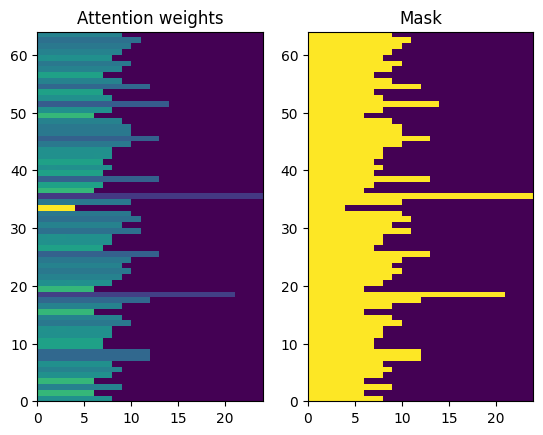

In [ ]:
attention_weights = attention_layer.last_attention_weights
mask=(ex_context_tok != 0).numpy()

plt.subplot(1, 2, 1)
plt.pcolormesh(mask*attention_weights[:, 0, :])
plt.title('Attention weights')

plt.subplot(1, 2, 2)
plt.pcolormesh(mask)
plt.title('Mask');


## Decoder

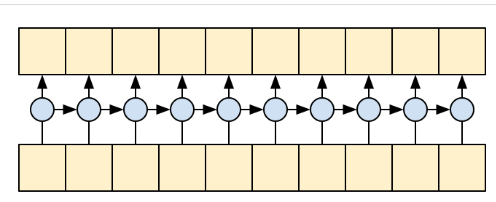

In [ ]:
class Decoder(tf.keras.layers.Layer):
  @classmethod
  def add_method(cls, fun):
    setattr(cls, fun.__name__, fun)
    return fun

  def __init__(self, text_processor, units):
    super(Decoder, self).__init__()
    self.text_processor = text_processor
    self.vocab_size = text_processor.vocabulary_size()
    self.word_to_id = tf.keras.layers.StringLookup(
        vocabulary=text_processor.get_vocabulary(),
        mask_token='', oov_token='[UNK]')
    self.id_to_word = tf.keras.layers.StringLookup(
        vocabulary=text_processor.get_vocabulary(),
        mask_token='', oov_token='[UNK]',
        invert=True)
    self.start_token = self.word_to_id('[START]')
    self.end_token = self.word_to_id('[END]')

    self.units = units


    # 1. The embedding layer converts token IDs to vectors
    self.embedding = Embedding(self.vocab_size, units, mask_zero=True)

    # 2. The RNN keeps track of what's been generated so far.
    self.rnn = GRU(units, return_sequences=True, return_state=True, recurrent_initializer='glorot_uniform')

    # 3. The RNN output will be the query for the attention layer.
    self.attention = CrossAttention(units)

    # 4. This fully connected layer produces the logits for each
    # output token.
    self.output_layer = Dense(self.vocab_size)

In [ ]:
@Decoder.add_method
def call(self, context, x, state=None, return_state=False):

  shape_checker = ShapeChecker()
  shape_checker(x, 'batch t')
  shape_checker(context, 'batch s units')

  # 1. Lookup the embeddings
  x = self.embedding(x)
  shape_checker(x, 'batch t units')

  # 2. Process the target sequence.
  x, state = self.rnn(x, initial_state=state)
  shape_checker(x, 'batch t units')

  # 3. Use the RNN output as the query for the attention over the context.
  x = self.attention(x, context)
  self.last_attention_weights = self.attention.last_attention_weights
  shape_checker(x, 'batch t units')
  shape_checker(self.last_attention_weights, 'batch t s')

  # Step 4. Generate logit predictions for the next token.
  logits = self.output_layer(x)

  shape_checker(logits, 'batch t target_vocab_size')

  if return_state:
    return logits, state
  else:
    return logits

In [ ]:
decoder = Decoder(target_text_processor, latent_dim)

In [ ]:
logits = decoder(ex_context, ex_tar_in)

print(f'encoder output shape: (batch, s, units) {ex_context.shape}')
print(f'input target tokens shape: (batch, t) {ex_tar_in.shape}')
print(f'logits shape shape: (batch, target_vocabulary_size) {logits.shape}')

encoder output shape: (batch, s, units) (64, 24, 256)
input target tokens shape: (batch, t) (64, 20)
logits shape shape: (batch, target_vocabulary_size) (64, 20, 5000)


In [ ]:
@Decoder.add_method
def get_initial_state(self, context):
  batch_size = tf.shape(context)[0]
  start_tokens = tf.fill([batch_size, 1], self.start_token)
  done = tf.zeros([batch_size, 1], dtype=tf.bool)
  embedded = self.embedding(start_tokens)
  return start_tokens, done, self.rnn.get_initial_state(embedded)[0]

In [ ]:
@Decoder.add_method
def tokens_to_text(self, tokens):
  words = self.id_to_word(tokens)
  result = tf.strings.reduce_join(words, axis=-1, separator=' ')
  result = tf.strings.regex_replace(result, '^ *\[START\] *', '')
  result = tf.strings.regex_replace(result, ' *\[END\] *$', '')
  return result

In [ ]:
@Decoder.add_method
def get_next_token(self, context, next_token, done, state, temperature = 0.0):
  logits, state = self(
    context, next_token,
    state = state,
    return_state=True)

  if temperature == 0.0:
    next_token = tf.argmax(logits, axis=-1)
  else:
    logits = logits[:, -1, :]/temperature
    next_token = tf.random.categorical(logits, num_samples=1)

  # If a sequence produces an `end_token`, set it `done`
  done = done | (next_token == self.end_token)
  # Once a sequence is done it only produces 0-padding.
  next_token = tf.where(done, tf.constant(0, dtype=tf.int64), next_token)

  return next_token, done, state

In [ ]:
# Setup the loop variables.
next_token, done, state = decoder.get_initial_state(ex_context)
tokens = []

for n in range(10):
  # Run one step.
  next_token, done, state = decoder.get_next_token(
      ex_context, next_token, done, state, temperature=1.0)
  # Add the token to the output.
  tokens.append(next_token)

# Stack all the tokens together.
tokens = tf.concat(tokens, axis=-1) # (batch, t)

# Convert the tokens back to a a string
result = decoder.tokens_to_text(tokens)
result[:3].numpy()

array([b'motorcycle wholl hell tunnel absent exception focused holds confess refugees',
       b'along gains prohibited twin swept password crop spain mother steam',
       b'introduce ships hurricane slim china unsuccessful year conditioner dead copy'],
      dtype=object)

## Training

In [ ]:
class Translator(tf.keras.Model):     # definimos una clase llamada translator de la cual viene heredada de tf.keras.Model, se definine el metodo de clase add_method
  @classmethod
  def add_method(cls, fun):  #definimos dos argumentos que son cls, fun
    setattr(cls, fun.__name__, fun)
    return fun

  def __init__(self, units, context_text_processor, target_text_processor): # inicializamos una instancia en la clase Traslator
    super().__init__()
    # Build the encoder and decoder
    encoder = Encoder(context_text_processor, units)
    decoder = Decoder(target_text_processor, units)   # es_processorto se hace para que los objetos esten disponobles a lo largo de la clase

    self.encoder = encoder
    self.decoder = decoder

  def call(self, inputs):
    context, x = inputs
    context = self.encoder(context)
    logits = self.decoder(context, x)# Continuation of the previous code

    #TODO(b/250038731): remove this
    try:
      # Delete the keras mask, so keras doesn't scale the loss+accuracy.
      del logits._keras_mask
    except AttributeError:
      pass

    return logits

In [ ]:
model = Translator(latent_dim, context_text_processor, target_text_processor)

logits = model((ex_context_tok, ex_tar_in))

print(f'Context tokens, shape: (batch, s, units) {ex_context_tok.shape}')
print(f'Target tokens, shape: (batch, t) {ex_tar_in.shape}')
print(f'logits, shape: (batch, t, target_vocabulary_size) {logits.shape}')

Context tokens, shape: (batch, s, units) (64, 24)
Target tokens, shape: (batch, t) (64, 20)
logits, shape: (batch, t, target_vocabulary_size) (64, 20, 5000)


In [ ]:
model.summary()

Model: "translator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_1 (Encoder)         multiple                  2069504   
                                                                 
 decoder_1 (Decoder)         multiple                  3223432   
                                                                 
Total params: 5,292,936
Trainable params: 5,292,936
Non-trainable params: 0
_________________________________________________________________


In [ ]:
def masked_loss(y_true, y_pred):
    # Calculate the loss for each item in the batch.
    loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(
        from_logits=True, reduction='none')
    loss = loss_fn(y_true, y_pred)

    # Mask off the losses on padding.
    mask = tf.cast(y_true != 0, loss.dtype)
    loss *= mask

    # Return the total.
    return tf.reduce_sum(loss)/tf.reduce_sum(mask)

In [ ]:
def masked_acc(y_true, y_pred):
    # Calculate the loss for each item in the batch.
    y_pred = tf.argmax(y_pred, axis=-1)
    y_pred = tf.cast(y_pred, y_true.dtype)

    match = tf.cast(y_true == y_pred, tf.float32)
    mask = tf.cast(y_true != 0, tf.float32)

    return tf.reduce_sum(match)/tf.reduce_sum(mask)

In [ ]:
model.compile(optimizer='adam',
              loss=masked_loss,
              metrics=[masked_acc, masked_loss])

In [ ]:
vocab_size = 1.0 * target_text_processor.vocabulary_size()

{"expected_loss": tf.math.log(vocab_size).numpy(),
 "expected_acc": 1/vocab_size}

{'expected_loss': 8.517193, 'expected_acc': 0.0002}

In [ ]:
model.evaluate(val_ds, steps=20, return_dict=True)

20/20 [==============================] - 14s 174ms/step - loss: 8.5042 - masked_acc: 9.2593e-05 - masked_loss: 8.5042


{'loss': 8.504217147827148,
 'masked_acc': 9.259259240934625e-05,
 'masked_loss': 8.504217147827148}

In [ ]:
history = model.fit(
    train_ds.repeat(),
    epochs=100,
    steps_per_epoch = 100,
    validation_data = val_ds,
    validation_steps = 20,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(patience=3)])

Epoch 1/100
100/100 [==============================] - 58s 486ms/step - loss: 5.0157 - masked_acc: 0.2591 - masked_loss: 5.0157 - val_loss: 4.0873 - val_masked_acc: 0.3573 - val_masked_loss: 4.0873
Epoch 2/100
100/100 [==============================] - 48s 485ms/step - loss: 3.7034 - masked_acc: 0.4010 - masked_loss: 3.7034 - val_loss: 3.3271 - val_masked_acc: 0.4489 - val_masked_loss: 3.3271
Epoch 3/100
100/100 [==============================] - 47s 472ms/step - loss: 3.1207 - masked_acc: 0.4821 - masked_loss: 3.1207 - val_loss: 2.8223 - val_masked_acc: 0.5200 - val_masked_loss: 2.8223
Epoch 4/100
100/100 [==============================] - 45s 452ms/step - loss: 2.6767 - masked_acc: 0.5402 - masked_loss: 2.6767 - val_loss: 2.4747 - val_masked_acc: 0.5705 - val_masked_loss: 2.4747
Epoch 5/100
100/100 [==============================] - 46s 464ms/step - loss: 2.4105 - masked_acc: 0.5803 - masked_loss: 2.4105 - val_loss: 2.1660 - val_masked_acc: 0.6139 - val_masked_loss: 2.1660
Epoch 6/10

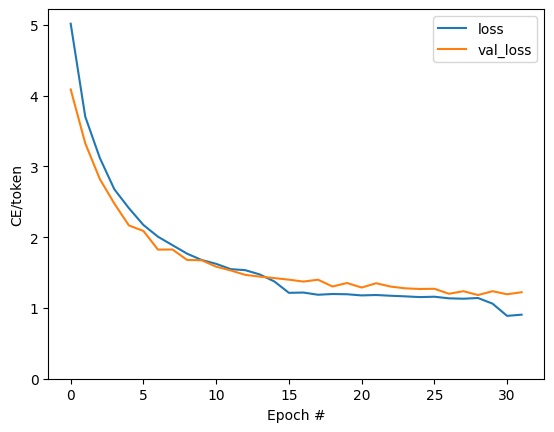

In [ ]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch #')
plt.ylabel('CE/token')
plt.legend()

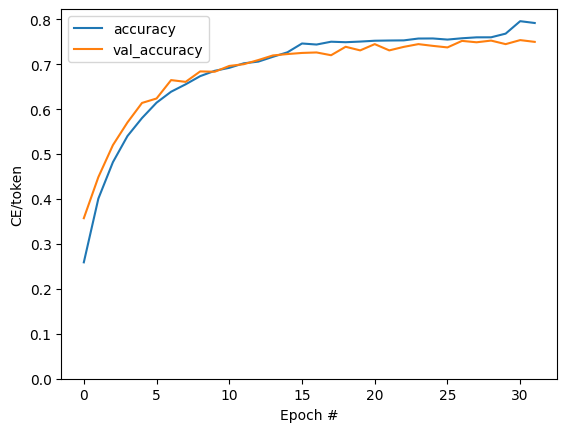

In [ ]:
plt.plot(history.history['masked_acc'], label='accuracy')
plt.plot(history.history['val_masked_acc'], label='val_accuracy')
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch #')
plt.ylabel('CE/token')
plt.legend()

In [ ]:
#@title
@Translator.add_method
def translate(self,
              texts, *,
              max_length=50,
              temperature=0.0):
  # Process the input texts
  context = self.encoder.convert_input(texts)
  batch_size = tf.shape(texts)[0]

  # Setup the loop inputs
  tokens = []
  attention_weights = []
  next_token, done, state = self.decoder.get_initial_state(context)

  for _ in range(max_length):
    # Generate the next token
    next_token, done, state = self.decoder.get_next_token(
        context, next_token, done,  state, temperature)

    # Collect the generated tokens
    tokens.append(next_token)
    attention_weights.append(self.decoder.last_attention_weights)

    if tf.executing_eagerly() and tf.reduce_all(done):
      break

  # Stack the lists of tokens and attention weights.
  tokens = tf.concat(tokens, axis=-1)   # t*[(batch 1)] -> (batch, t)
  self.last_attention_weights = tf.concat(attention_weights, axis=1)  # t*[(batch 1 s)] -> (batch, t s)

  result = self.decoder.tokens_to_text(tokens)
  return result

In [ ]:
result = model.translate(['¿Él todavía está en casa?']) # Are you still home
result[0].numpy().decode()

'is he still at home ? '

In [ ]:
#@title
@Translator.add_method
def plot_attention(self, text, **kwargs):
  assert isinstance(text, str)
  output = self.translate([text], **kwargs)
  output = output[0].numpy().decode()

  attention = self.last_attention_weights[0]

  context = tf_lower_and_split_punct(text)
  context = context.numpy().decode().split()

  output = tf_lower_and_split_punct(output)
  output = output.numpy().decode().split()[1:]

  fig = plt.figure(figsize=(10, 10))
  ax = fig.add_subplot(1, 1, 1)

  ax.matshow(attention, cmap='viridis', vmin=0.0)

  fontdict = {'fontsize': 14}

  ax.set_xticklabels([''] + context, fontdict=fontdict, rotation=90)
  ax.set_yticklabels([''] + output, fontdict=fontdict)

  ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
  ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

  ax.set_xlabel('Input text')
  ax.set_ylabel('Output text')

<ipython-input-52-93059eaa9bfc>:23: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + context, fontdict=fontdict, rotation=90)
<ipython-input-52-93059eaa9bfc>:24: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + output, fontdict=fontdict)


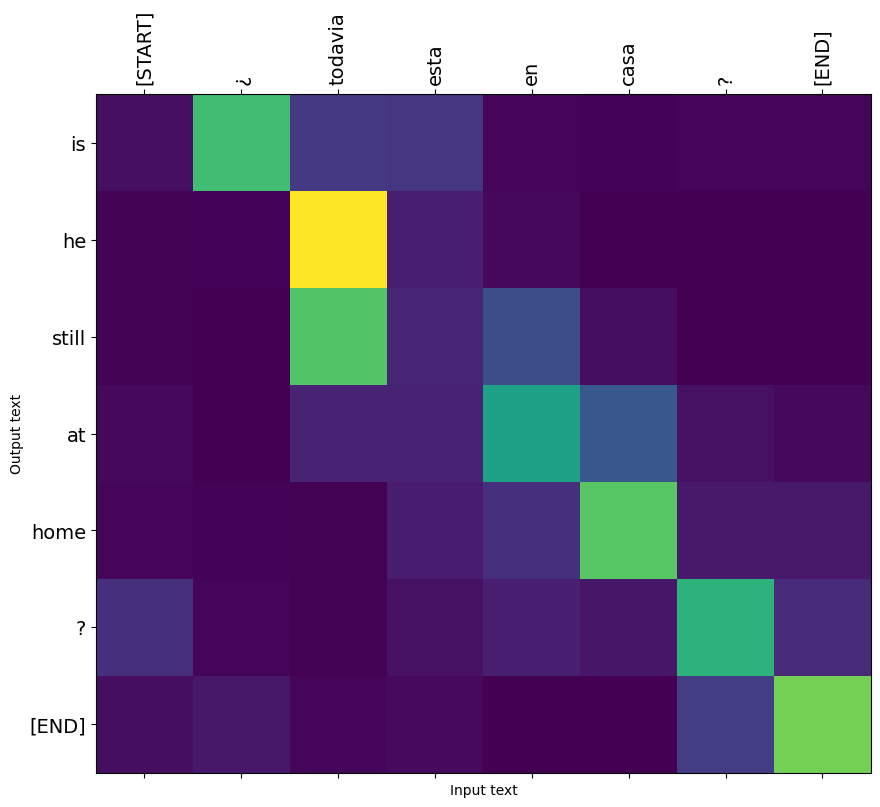

In [ ]:
model.plot_attention('¿Todavía está en casa?') # Are you still home

In [ ]:
inp = input("Ingresa un texto: ")

result_translate = model.translate([inp])
print(result_translate[0].numpy().decode())

Ingresa un texto: Hola, ¿Cómo estás?
hi , are you ? 


In [ ]:
while True:
  qt = input("¿Desea ingresar un texto?: ")
  if qt == "Si":
    user = input("Ingrese el texto: ")
    result = model.translate([user])
    print(result[0].numpy().decode())
  else:
    break


¿Desea ingresar un texto?: Si
Ingrese el texto: ¿Cómo estas?
how are you ? 
¿Desea ingresar un texto?: n
